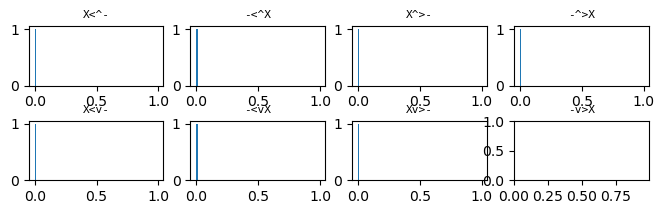

callback_count: 24, duration: 1.267719, fps: 18.93
callback_count: 48, duration: 1.482064, fps: 32.39
callback_count: 72, duration: 1.690655, fps: 42.59
callback_count: 96, duration: 1.904428, fps: 50.41
callback_count: 120, duration: 2.114677, fps: 56.75
callback_count: 144, duration: 2.327172, fps: 61.88
callback_count: 168, duration: 2.541155, fps: 66.11
callback_count: 192, duration: 2.761214, fps: 69.53
callback_count: 216, duration: 2.971493, fps: 72.69
callback_count: 240, duration: 3.179089, fps: 75.49
callback_count: 264, duration: 3.393712, fps: 77.79
callback_count: 288, duration: 3.603251, fps: 79.93
callback_count: 312, duration: 3.813496, fps: 81.81
callback_count: 336, duration: 4.019109, fps: 83.60
callback_count: 360, duration: 4.234207, fps: 85.02
callback_count: 384, duration: 4.446299, fps: 86.36
callback_count: 408, duration: 4.659585, fps: 87.56
callback_count: 432, duration: 4.888936, fps: 88.36
callback_count: 456, duration: 5.100477, fps: 89.40
callback_count: 

Traceback (most recent call last):
  File "/home/ros/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_13435/126347321.py", line 129, in <module>
    main()
  File "/tmp/ipykernel_13435/126347321.py", line 122, in main
    rclpy.spin(minimal_subscriber)
  File "/opt/ros/galactic/lib/python3.8/site-packages/rclpy/__init__.py", line 196, in spin
    executor.spin_once()
  File "/opt/ros/galactic/lib/python3.8/site-packages/rclpy/executors.py", line 711, in spin_once
    handler()
  File "/opt/ros/galactic/lib/python3.8/site-packages/rclpy/task.py", line 239, in __call__
    self._handler.send(None)
  File "/opt/ros/galactic/lib/python3.8/site-packages/rclpy/executors.py", line 418, in handler
    await call_coroutine(entity, arg)
  File "/opt/ros/galactic/lib/python3.8/site-packages/rclpy/executors.py", line 343, in _execute_subscription
    await await_or_execute(sub.c

In [1]:
from datetime import datetime
import rclpy
from rclpy.node import Node
from rclpy.qos import QoSProfile, QoSReliabilityPolicy, QoSHistoryPolicy

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from sensor_msgs.msg._range import Range
from std_msgs.msg import String

class MinimalSubscriber(Node):

    def __init__(self):
        super().__init__('minimal_subscriber')
        self.start_time = datetime.now()
        self.callback_count = 0

        # These are the title strings shown per sensor histogram.
        # They are a shortcut, for me, as to the physical position of the corresponding sensor.
        # The 'X" shows where the sensor is located. 
        # The '<' and '>' show whether the sensor is on the left or right side of the robot frame.
        # The '^' and 'v' show whether the sensor is on the front or rear of the robot frame.
        self.sensor_names = [['X<^-', '-<^X', 'X^>-', '-^>X'],
                             ['X<v-', '-<vX', 'Xv>-', '-v>X']]
        self.number_sensors = 8 # There are 8 sensors.
        self.number_values_to_cache = 20 # I want to show the variance over this number of the last readings.
        self.last_n_values_per_sensor = np.zeros(
            (self.number_sensors, self.number_values_to_cache), dtype='float')
        self.next_index_number = np.zeros((self.number_sensors), dtype='int32')

        # Create an array of histograms.
        # Two rows for front vs back of robot.
        # Four columns for left-sideways, left-front-or-back, right-front-or-back, right-sideways position.
        self.figure, self.axis = plt.subplots(
            nrows=2, ncols=4, sharex=False, sharey=False, squeeze=False, figsize=(8, 2))
        
        # Set the window title.
        self.figure.canvas.set_window_title('Time Of Flight Sensors step')

        # Create the x-axis values. I'm interested in only ranges from 0.00 to 1.00 meters.
        self.bins = [x / 100.0 for x in range(100)]

        # Make it all look pretty.
        plt.subplots_adjust(hspace=0.6)
        plt.autoscale(enable=True, axis='both', tight=True)
        plt.rcParams['lines.linewidth'] = 1

        # Set up the ROS 2 quality of service in order to read the sensor data.
        qos_profile = QoSProfile(
            reliability=QoSReliabilityPolicy.BEST_EFFORT,
            history=QoSHistoryPolicy.KEEP_LAST,
            depth=1
        )
        
        # Subscribe to the sensor topics.
        for sensor_number in range(8):
            self.subscription = self.create_subscription(
                Range,
                '/tof{s}Sensor'.format(s = sensor_number),
                self.listener_callback,
                qos_profile,
            )

        # Set up the 8 histogram formats and titles.
        self.patches = [1, 2, 3, 4, 5, 6, 7, 8]
        for row in range(2):
            for col in range(4):
                n, bins, patches = self.axis[row][col].hist(
                    self.last_n_values_per_sensor[row][col], self.bins, histtype='bar')
                self.patches[(row * 4) + col] = patches
                self.axis[row, col].set_title(
                    self.sensor_names[row][col], fontsize=8, fontfamily='monospace')
        
        # Let's go.
        plt.ion()
        plt.show()
        
        self.subscription  # prevent unused variable warning


    # Process a time-of-flight sensor message of type Range.
    def listener_callback(self, msg):
        self.callback_count = self.callback_count + 1
        sensor_number = int(msg.header.frame_id[-1])    # Get the sensor number.
        range_value = msg.range
        if (range_value > 2.0):
            # If the range is greater than 2 meters, ignore it by setting it to zero.
            range_value = 0
            
        # Capture the last readings of the sensor in a ring buffer.
        self.last_n_values_per_sensor[sensor_number][self.next_index_number[sensor_number]] = range_value

        if (self.callback_count % 24) == 0:
            # Peridically update the plots.
            for s in range(8):
                # For each sensor, create a histogram.
                data = self.last_n_values_per_sensor[s]
                n, _ = np.histogram(data, self.bins, density=True)
                max = n.max()
                for count, rect in zip(n, self.patches[s]):
                    rect.set_height(count / max) # Normalize the height of the rectangle.
            self.figure.canvas.draw()
            self.figure.canvas.flush_events()
            
            # Print out the frames per second of sensor data for all 8 sensors since the last plot update.
            # Divide by 8 if you want to know the frames per second per sensor.
            duration = datetime.now() - self.start_time
            fps = self.callback_count / (duration.seconds + (duration.microseconds / 1000000.0))
            print("callback_count: %d, duration: %f, fps: %3.2f" % (self.callback_count, (duration.seconds + (duration.microseconds / 1000000.0)), fps))

        # Update the ring buffer index.
        self.next_index_number[sensor_number] = self.next_index_number[sensor_number] + 1
        if self.next_index_number[sensor_number] >= self.number_values_to_cache:
            self.next_index_number[sensor_number] = 0

def main(args=None):
    rclpy.init(args=args)

    minimal_subscriber = MinimalSubscriber()

    rclpy.spin(minimal_subscriber)

    minimal_subscriber.destroy_node()
    rclpy.shutdown()


if __name__ == '__main__':
    main()
